# **ML code written on Jan, 19-20, 2023** #

***wawfm15222***

the dataset is from -> https://www.kaggle.com/datasets/sshikamaru/car-object-detection

resourses -> 
1. YOLOv7 How to Use ? – Best Tutorial simple https://inside-machinelearning.com/en/use-yolov7/
2. Notebook https://www.kaggle.com/code/eisgandar/detect-objects-by-using-yolo-v5 
3.https://github.com/ultralytics/ultralytics

FIRST PART :
Yolov5 is used here:"YOLO stands for You Only Look Once, and 5 refers to the seventh version of the algorithm. 

YOLO is an object detection algorithm that uses PyTorch as its base for coding. It is famous for detecting objects in a real-time environment."



In [1]:
#!git clone https://github.com/WongKinYiu/yolov7.git
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14995, done.
remote: Total 14995 (delta 0), reused 0 (delta 0), pack-reused 14995
Receiving objects: 100% (14995/14995), 14.02 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (10286/10286), done.


In [2]:
!pip install -q -U pycocotools

In [3]:
!pip install -U pip setuptools 

In [4]:
!pip install -q -r yolov5/requirements.txt
!cp yolov5/requirements.txt ./

In [5]:
import time
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random 

import cv2
import torch  # pyTorch
import shutil #The shutil module offers a number of high-level operations on files and collections of files. In particular, functions are provided which support file copying and removal
from tqdm.auto import tqdm # is a Python library for adding progress bar. It lets you configure and display a progress bar with metrics you want to track
from termcolor import colored #Very simple Python library for color and formatting in terminal

from IPython.display import Image, clear_output
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
df_t = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
#df_t = df_train

# **Basic EDA** #

In [7]:
df_t.head(10)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
5,vid_4_10100.jpg,447.568741,160.625804,582.083936,232.517696
6,vid_4_10120.jpg,168.755427,180.677284,304.738061,246.700450
7,vid_4_10140.jpg,0.000000,188.991313,85.111433,249.145753
8,vid_4_1020.jpg,202.506512,189.480373,239.192475,229.094273
9,vid_4_1040.jpg,116.416787,189.969434,180.494935,229.094273


In [8]:
df_t.shape

(559, 5)

In [9]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB


In [10]:
df_t.dtypes

image     object
xmin     float64
ymin     float64
xmax     float64
ymax     float64
dtype: object

In [11]:
df_t.describe()

,xmin,ymin,xmax,ymax
count,559.000000,559.000000,559.000000,559.000000
mean,263.387486,186.517539,365.324845,231.500472
std,207.368388,9.315974,213.501175,13.987176
min,0.000000,148.399292,28.556446,198.321729
25%,61.387844,180.109294,166.309696,223.225547
50%,236.746744,187.524131,348.585579,230.561454
75%,446.835022,193.881918,571.322721,237.897362
max,645.183792,208.064672,676.000000,308.322072


In [12]:
df_t['image'] = df_t['image'].apply(lambda x: x.split('.')[0])
df_t

,image,xmin,ymin,xmax,ymax
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960,487.428988,172.233646,616.917699,228.839864


In [13]:
df_t.rename(columns={"image":"image_id"}, inplace=True)

# **Preprocessing** #

In [14]:
image_height = 380
image_width = 676
no_channels = 3
source = "training_images"

Add new columns from the existing dataset , new columns are:
1. x_center
2. y_center
3. width
4. height
5. calsses

In [15]:
df_t["image_id"] = df_t["image_id"].apply(lambda x: x.split('.')[0])
df_t["x_center"] = (df_t["xmin"] + df_t["xmax"]) / 2
df_t["y_center"] = (df_t["ymin"] + df_t["ymax"]) / 2
df_t["width"] = df_t["xmax"] - df_t["xmin"]
df_t["height"] = df_t["ymax"] - df_t["ymin"]
df_t["classes"] = 0
df_t["x_center"] = df_t["x_center"] / image_width
df_t["width"] = df_t["width"] / image_width
df_t["y_center"] = df_t["y_center"] / image_height
df_t["height"] = df_t["height"] / image_height

Display the new columns

In [16]:
df_t.head(10)

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,width,height,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0
5,vid_4_10100,447.568741,160.625804,582.083936,232.517696,0.761577,0.517294,0.198987,0.189189,0
6,vid_4_10120,168.755427,180.677284,304.738061,246.700450,0.350217,0.562339,0.201158,0.173745,0
7,vid_4_10140,0.000000,188.991313,85.111433,249.145753,0.062952,0.576496,0.125904,0.158301,0
8,vid_4_1020,202.506512,189.480373,239.192475,229.094273,0.326700,0.550756,0.054269,0.104247,0
9,vid_4_1040,116.416787,189.969434,180.494935,229.094273,0.219609,0.551400,0.094790,0.102960,0


image id & shape

In [17]:
index = list(set(df_t.image_id))
image = random.choice(index)
img = cv2.imread("/kaggle/input/car-object-detection/data/training_images/{}.jpg".format(image))
print("Shape of image: ", img.shape)
print("--------------------")
print("\nImage id: ", image)
print("--------------------")
print("\nThree examples: ", "\n", img[0:2])

Shape of image:  (380, 676, 3)
--------------------

Image id:  vid_4_9080
--------------------

Three examples:  
 [[[251 185 106]
  [251 185 106]
  [251 185 106]
  ...
  [253 186 111]
  [252 185 110]
  [252 185 110]]

 [[254 188 109]
  [253 187 108]
  [252 186 107]
  ...
  [253 186 111]
  [253 186 111]
  [254 187 112]]]


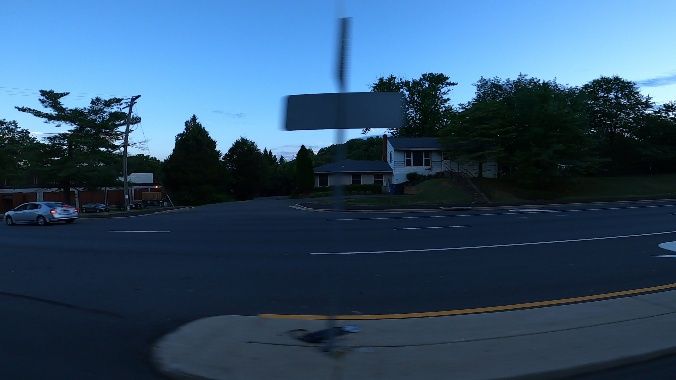

In [18]:
image = random.choice(index)
Image(filename = "/kaggle/input/car-object-detection/data/training_images/{}.jpg".format(image), width = 800)

In [19]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.7.12 torch-1.11.0+cpu CPU

100%|███████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 105MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 226.4ms
image 2/175 /kaggle/input/car-object-detection/data/testing

In [20]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.7.12 torch-1.11.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 203.2ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 416x704 (no detections), 166.3ms
image 3/175 /kaggle/inpu

In [21]:
predicted_files = []

for (dirpath, dirnames, filenames) in os.walk("/kaggle/working/yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)
    dirnames.extend(dirnames)
    
print("Names of 10 predicted images")
predicted_files[:10]

Names of 10 predicted images


['vid_5_31300.jpg',
 'vid_5_31080.jpg',
 'vid_5_29840.jpg',
 'vid_5_30760.jpg',
 'vid_5_27740.jpg',
 'vid_5_26780.jpg',
 'vid_5_29620.jpg',
 'vid_5_27380.jpg',
 'vid_5_29560.jpg',
 'vid_5_31700.jpg']

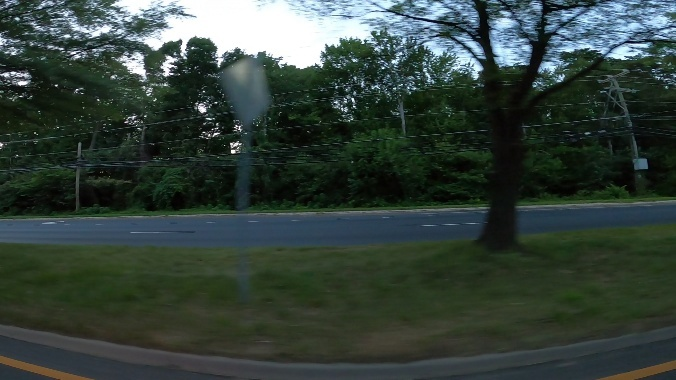

In [22]:
Image(filename = f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}',
      width = 800, height = 800, retina = False, embed = True)

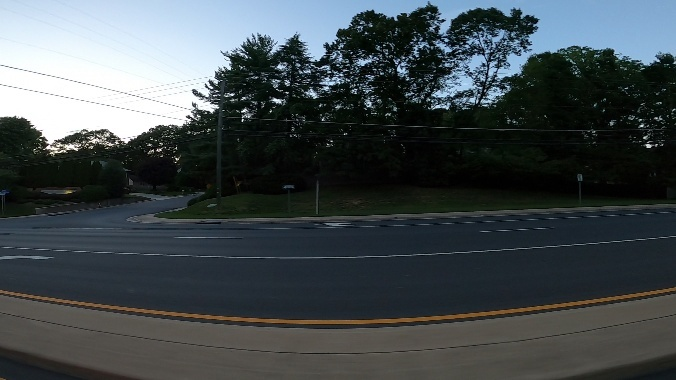

In [23]:
Image(filename = f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}',
      width = 800, height = 800, retina = False, embed = True)

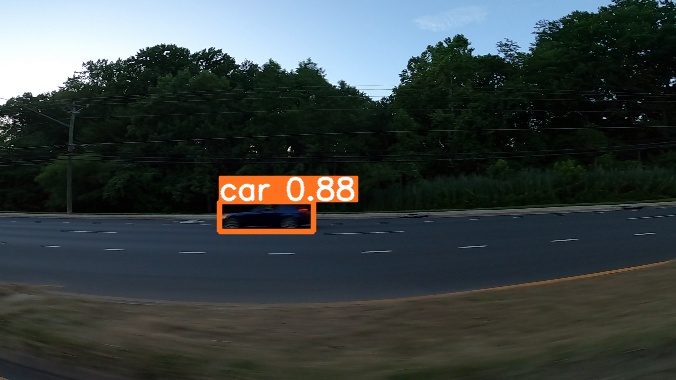

In [24]:
Image(filename = f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}',
      width = 800, height = 800, retina = False, embed = True)

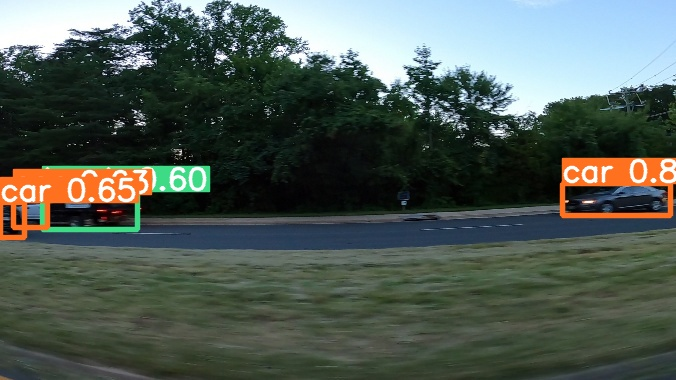

In [25]:
Image(filename = f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}',
      width = 800, height = 800, retina = False, embed = True)

# **Acknowledgement** #
* MUSTANGER : https://www.kaggle.com/eisgandar
for his amazing code at https://www.kaggle.com/code/eisgandar/detect-objects-by-using-yolo-v5
* Ritesh Yadav: https://www.linkedin.com/in/ritesh-yadav2011/
for his post & code at https://github.com/ultralytics/ultralytics

*Thank you!!*